In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import sys, distutils.core
sys.path.insert(0, os.path.abspath('../detectron2'))
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../projects/Panoptic-DeepLab/'))
os.environ['DETECTRON2_DATASETS'] = '/home/liwa/data/datasets/'

from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from detectron2.projects.panoptic_deeplab import add_panoptic_deeplab_config

from prediction import Predictor
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer

torch.set_num_threads(2)

/home/liwa/miniconda3/envs/oneformer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:8700m"
cfg = get_cfg()
add_panoptic_deeplab_config(cfg)
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("/home/liwa/data/oneformer_output/output/config.yaml")

cfg.MODEL.DEVICE = "cuda"
# into cpu model
# cfg.MODEL.SEM_SEG_HEAD.NORM = "BN"
# cfg.MODEL.INS_EMBED_HEAD.NORM = "BN"
# cfg.MODEL.RESNETS.NORM = "BN"

cfg.MODEL.PANOPTIC_DEEPLAB.TOP_K_INSTANCE = None
cfg.MODEL.PANOPTIC_DEEPLAB.INSTANCE_AREA_THRESHOLD = 3000

# cfg.MODEL.PANOPTIC_DEEPLAB.CENTER_THRESHOLD = 0.1
# cfg.MODEL.PANOPTIC_DEEPLAB.PREDICT_INSTANCES = False
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = os.path.abspath("/home/liwa/data/oneformer_output/output/model_0059999.pth")

# torch.save(model.state_dict(), "model.pth")
# torch.save(predictor.model.state_dict(), "/home/liwa/data/Oneformer_model/test_save_model.pth")

In [6]:
predictor = Predictor(cfg)

### Test

In [7]:
from pathlib import Path
from skimage.io import imread, imsave
import numpy as np

import matplotlib.pyplot as plt
from post_process_utils import get_largest_object, convert_to_rgb, segment_slide_window, segment_post_process
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
movie_path_list = list(Path("/home/liwa/data/mating_data/20250624_ywl065/").rglob("*_rigid.tif"))
movie_path_list = [str(x) for x in movie_path_list]
movie_path_list.sort()
movie_path_list

['/home/liwa/data/mating_data/20250624_ywl065/1_rigid/01_ywl065-06_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/02_ywl065-07_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/03_ywl065-10_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/04_ywl065-08_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/05_ywl065-09_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/06_ywl065-03_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/07_ywl065-02_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/08_ywl065-01_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/09_ywl065-04_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/10_ywl065-05_rigid.tif']

In [24]:
im = imread(movie_path_list[5])#[-1, 0, 1024:2048, 1024:2048]#[23, 0, 0:1300, 0:1300]
#im = convert_to_rgb(im)

In [25]:
im.shape

(181, 2, 2048, 2048)

In [18]:
with torch.no_grad():
    prediction_output = predictor(im)
    panoptic_seg, _ = prediction_output["panoptic_seg"]
    panoptic_seg = panoptic_seg.to("cpu")
    panopitc_labels = np.unique(panoptic_seg)
    panopitc_labels = panopitc_labels[panopitc_labels>1000]
    
    instances = prediction_output["instances"]
    scores = list(instances.center_scores.to("cpu"))
    bboxes = instances.pred_boxes.to("cpu")
    
    segments_info = []
    if len(panopitc_labels) == len(scores):
        for idx, panoptic_label in enumerate(panopitc_labels):
            a ,b, c, d = bboxes[idx].tensor[0]
            if (a == 0) | (b == 0) | (c == 1300) | (d == 1300) | (scores[idx] < 0.5):
                panoptic_seg[panoptic_seg==panoptic_label] = -1
                continue
            
            segments_info.append(
                {
                    "id": int(panoptic_label),
                    "category_id": int(panoptic_label // 1000),
                    "isthing": True,
                    "score": float(scores[idx]),
                }
            )

/home/liwa/miniconda3/envs/oneformer/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{1003: {'id': 1003, 'category_id': 1, 'isthing': True, 'score': 1.0149809122085571}, 1004: {'id': 1004, 'category_id': 1, 'isthing': True, 'score': 0.9832967519760132}, 1005: {'id': 1005, 'category_id': 1, 'isthing': True, 'score': 0.9892672896385193}, 1006: {'id': 1006, 'category_id': 1, 'isthing': True, 'score': 0.9897770881652832}, 1007: {'id': 1007, 'category_id': 1, 'isthing': True, 'score': 0.9866572022438049}, 1008: {'id': 1008, 'category_id': 1, 'isthing': True, 'score': 0.9732329845428467}, 1009: {'id': 1009, 'category_id': 1, 'isthing': True, 'score': 0.9527114033699036}, 1010: {'id': 1010, 'category_id': 1, 'isthing': True, 'score': 0.9960911273956299}, 1011: {'id': 1011, 'category_id': 1, 'isthing': True, 'score': 0.9684286713600159}, 1012: {'id': 1012, 'category_id': 1, 'isthing': True, 'score': 0.9768146276473999}, 1013: {'id': 1013, 'category_id': 1, 'isthing': True, 'score': 0.989262044429779}, 1014: {'id': 1014, 'category_id': 1, 'isthing': True, 'score': 0.99332535266

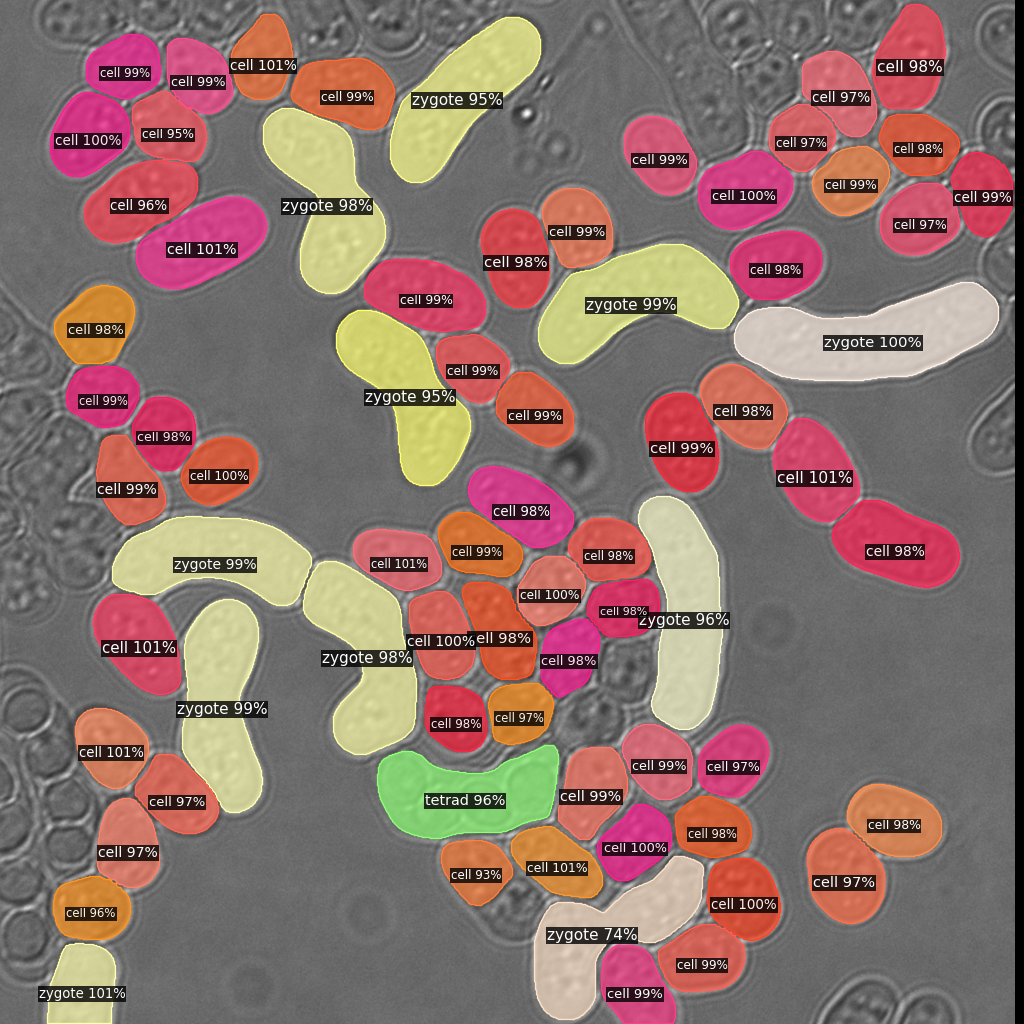

In [19]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_panoptic_seg(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

In [20]:
post_precessed_mask = segment_post_process(prediction_output)

In [26]:
import matplotlib.pyplot as plt

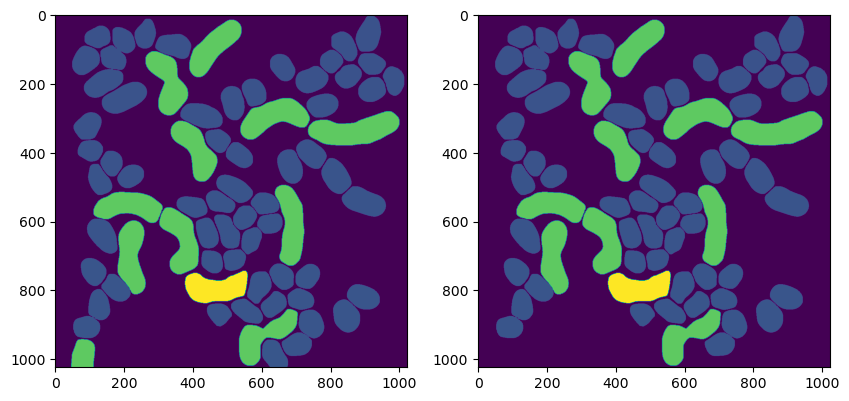

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(panoptic_seg)
axs[1].imshow(post_precessed_mask)

In [27]:
from tqdm import trange

In [ ]:
DIVISION = 1000
min_box = 0
max_box = 1300
crops = [[0, max_box ,0,max_box], [0, max_box ,2048-max_box,2048], [2048-max_box,2048,0,max_box], [2048-max_box,2048,2048-max_box,2048]]

for movie_path in movie_path_list:
    print(movie_path)
    movie = imread(movie_path)[:,0]
    segment_movie = np.zeros(movie.shape, dtype=np.uint16)
    for frame in trange(0, movie.shape[0]):
        try:
            segment_movie[frame] = segment_slide_window(predictor, movie[frame], crops, score_threshold=0.3, ins_threshold=0.6, area_threshold=1000)

        except Exception as e:
            print("Error occurred:", e)
            continue

    imsave(movie_path[:-4]+f"_mask.tif", segment_movie)
    del movie, segment_movie

/home/liwa/data/mating_data/20250624_ywl065/1_rigid/01_ywl065-06_rigid.tif


 42%|███████████████████████████████████████████████████████▊                                                                             | 76/181 [33:52<47:42, 27.26s/it]